# **Socio-economic Factors for Geographic Clustering**

-----------------------------------------
## **Context**
-----------------------------------------

Socio-economic factors are an important lens into the overall health of an economy. While GDP (total and per-capita) is usually the norm when investigating economies, there are several other factors which can also be used. This workbook will explore country socio-economic data via clustering.

Clustering is an un-supervised ML algorithm. We will explore K-means/medioids, Gaussian mixture models. Heirarchical as well as DBSCAN will be explored in a later notebook.

- **K-means clustering**: uses mean (or mediod) of data to form k number of clusters.
- **Gaussian mixuture models**: generalization of K-means, using both mean and variance of a gaussian distribution
- **Heirarichal clustering**: unlike K-means and GMM, do not need to set # of clusters (k) before hand. Builds dendogram trees to plot the data and then determine the number of clusters
- **DBSCAN**: generalization of Heirarichal clustering by adding an additional parameter which helps find elongated clusters

------------------------
## Dataset
-------------------------
The data has the following attributes:
- country: Name of the country
- child_mort: Death of children under 5 years of age per 1000 live births
- exports - Exports in % of the GDP per capita
- health - The total spend on health given as % of GDP
- imports - The value of imports given as % of GDP per capita
- income - The net income per person
- inflation - Inflation rate %
- life_expec - Average life expectancy in years
- total_fer - The fertility rate - Average children per woman in the country
- gdpp - GDP per capita

In the dataset, we will not do clustering on the GDP. We will rather try to understand the variation of other factors with GDP across the groups that we get.

## **Step 1 - Import Libraries and Examine Data**

In [26]:
!pip install scikit-learn-extra

import pandas as pd

import numpy as np

import matplotlib.pylab as plt

import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

# Importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from sklearn.mixture import GaussianMixture

from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN

# Silhouette score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")



     |████████████████████████████████| 389 kB 1.1 MB/s eta 0:00:01


In [9]:
#import the dataset
data = pd.read_csv("/Users/guransingh/Library/CloudStorage/OneDrive-Personal/Documents/Work/Python Notebooks/Python Notebooks/MIT/Socioeconomic_clustering/Country-data.csv")

data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
#check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
#check data shape
data.shape

(167, 10)

In [6]:
#breakup into numerical and categorical data
data_num=data.iloc[:,1:]
data_cat=data.iloc[:,0]

In [7]:
data_num.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [8]:
data_cat.head

<bound method NDFrame.head of 0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 167, dtype: object>

**Observations:**
  - All columns have 167 non-null values, i.e., there are **no missing values**.
 - All the **columns except the country name are numerical**.
 - Everything looks great, let's move ahead to check for duplicates.

## **Step 2 - Exploratory Data Analysis**

In [10]:
#lets check the mathematics statistics of the numerical data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


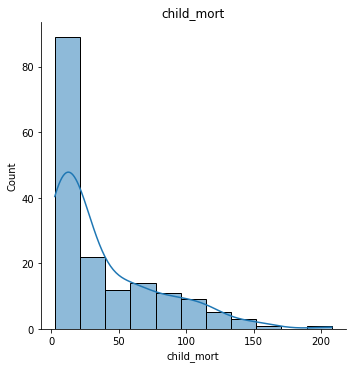

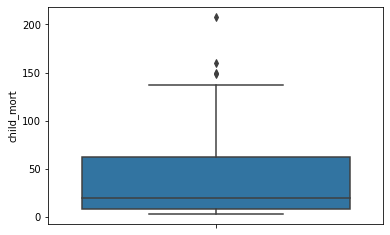

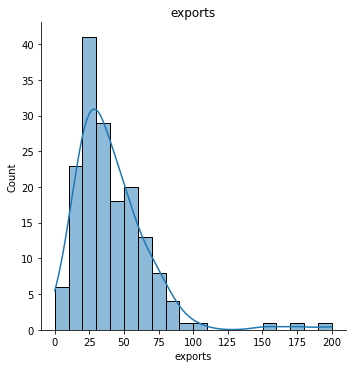

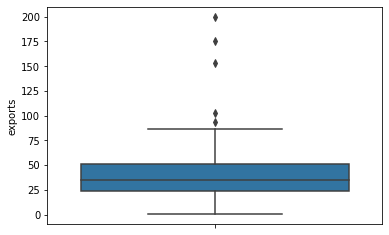

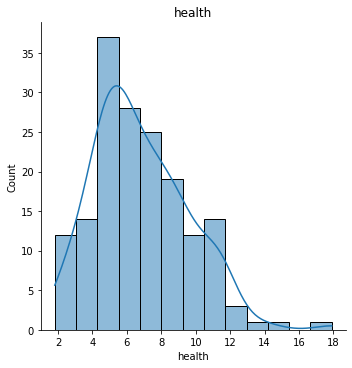

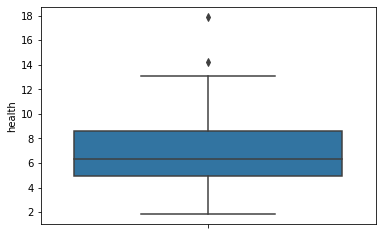

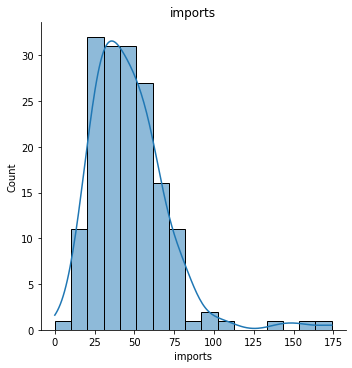

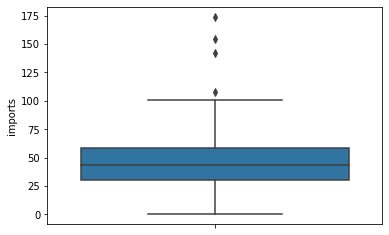

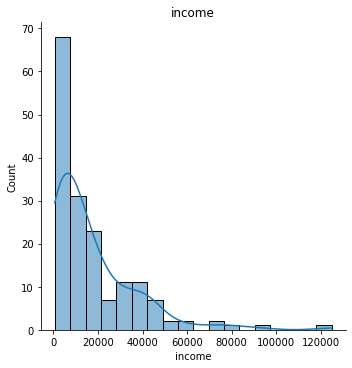

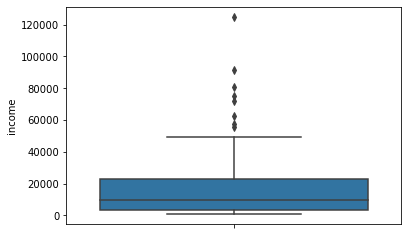

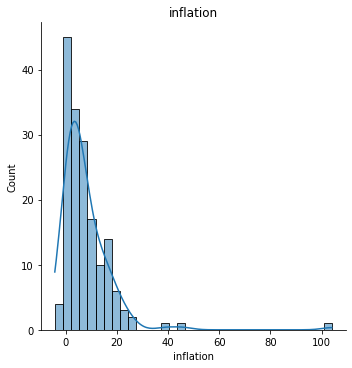

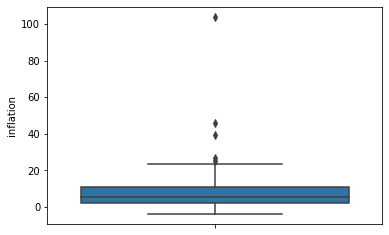

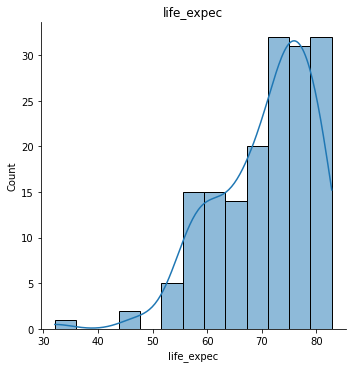

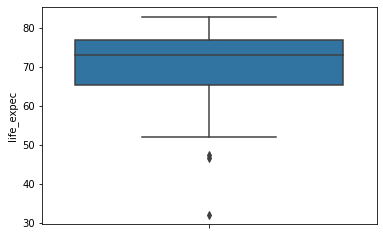

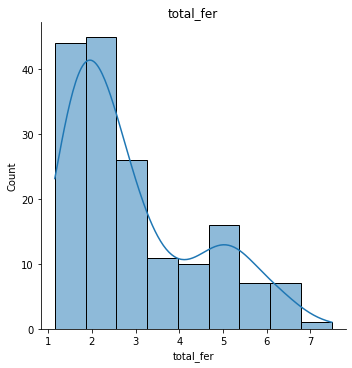

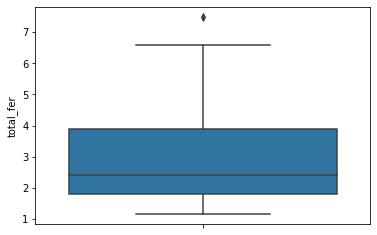

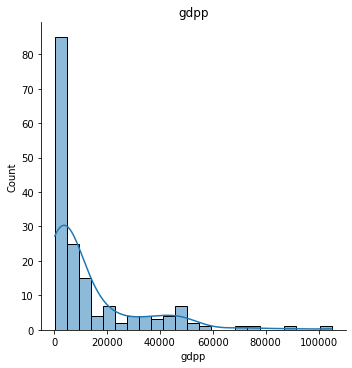

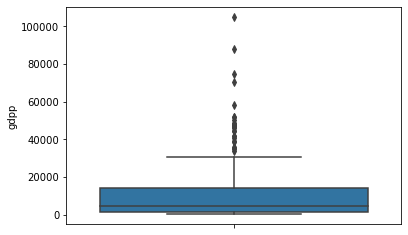

In [11]:
#lets plot the boxplots and historgrams for all the numerical data
for col in data_num.columns:
    sns.displot(data_num[col],kde=True)
    plt.title(col)
    plt.show()
    sns.boxplot(y=data_num[col])
    plt.show()

**Observations:**

- Most of the variables have skewed distributions.
- The life expectancy is the only variable which is skewed to the left meaning most of the countries have already been successful in achieving high life expectancy.

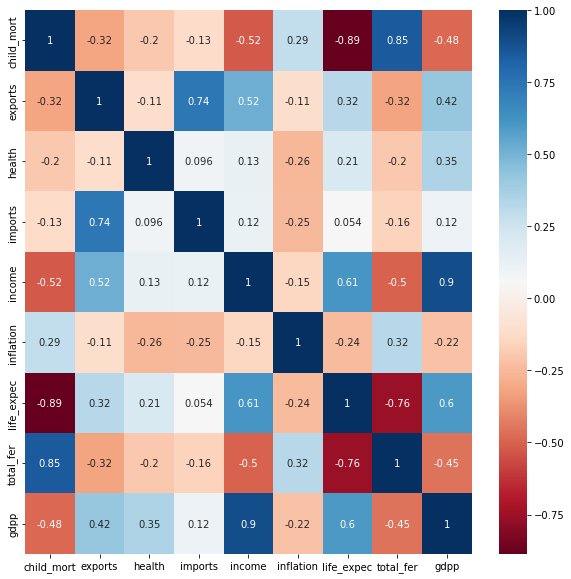

In [12]:
#lets plot a heat map of correlations of the numerical data
plt.figure(figsize  = (10, 10))

sns.heatmap(data.corr(), annot = True, cmap = "RdBu")

plt.show()

**Observations:**

- There is a strong positive correlation between gdpp and income. This makes sense. 
- The life expectancy is positively correlated with gdpp. This indicates that people live longer in richer countries. 
- There is a strong negative correlation between life expectancy and child mortality. This is understandable.

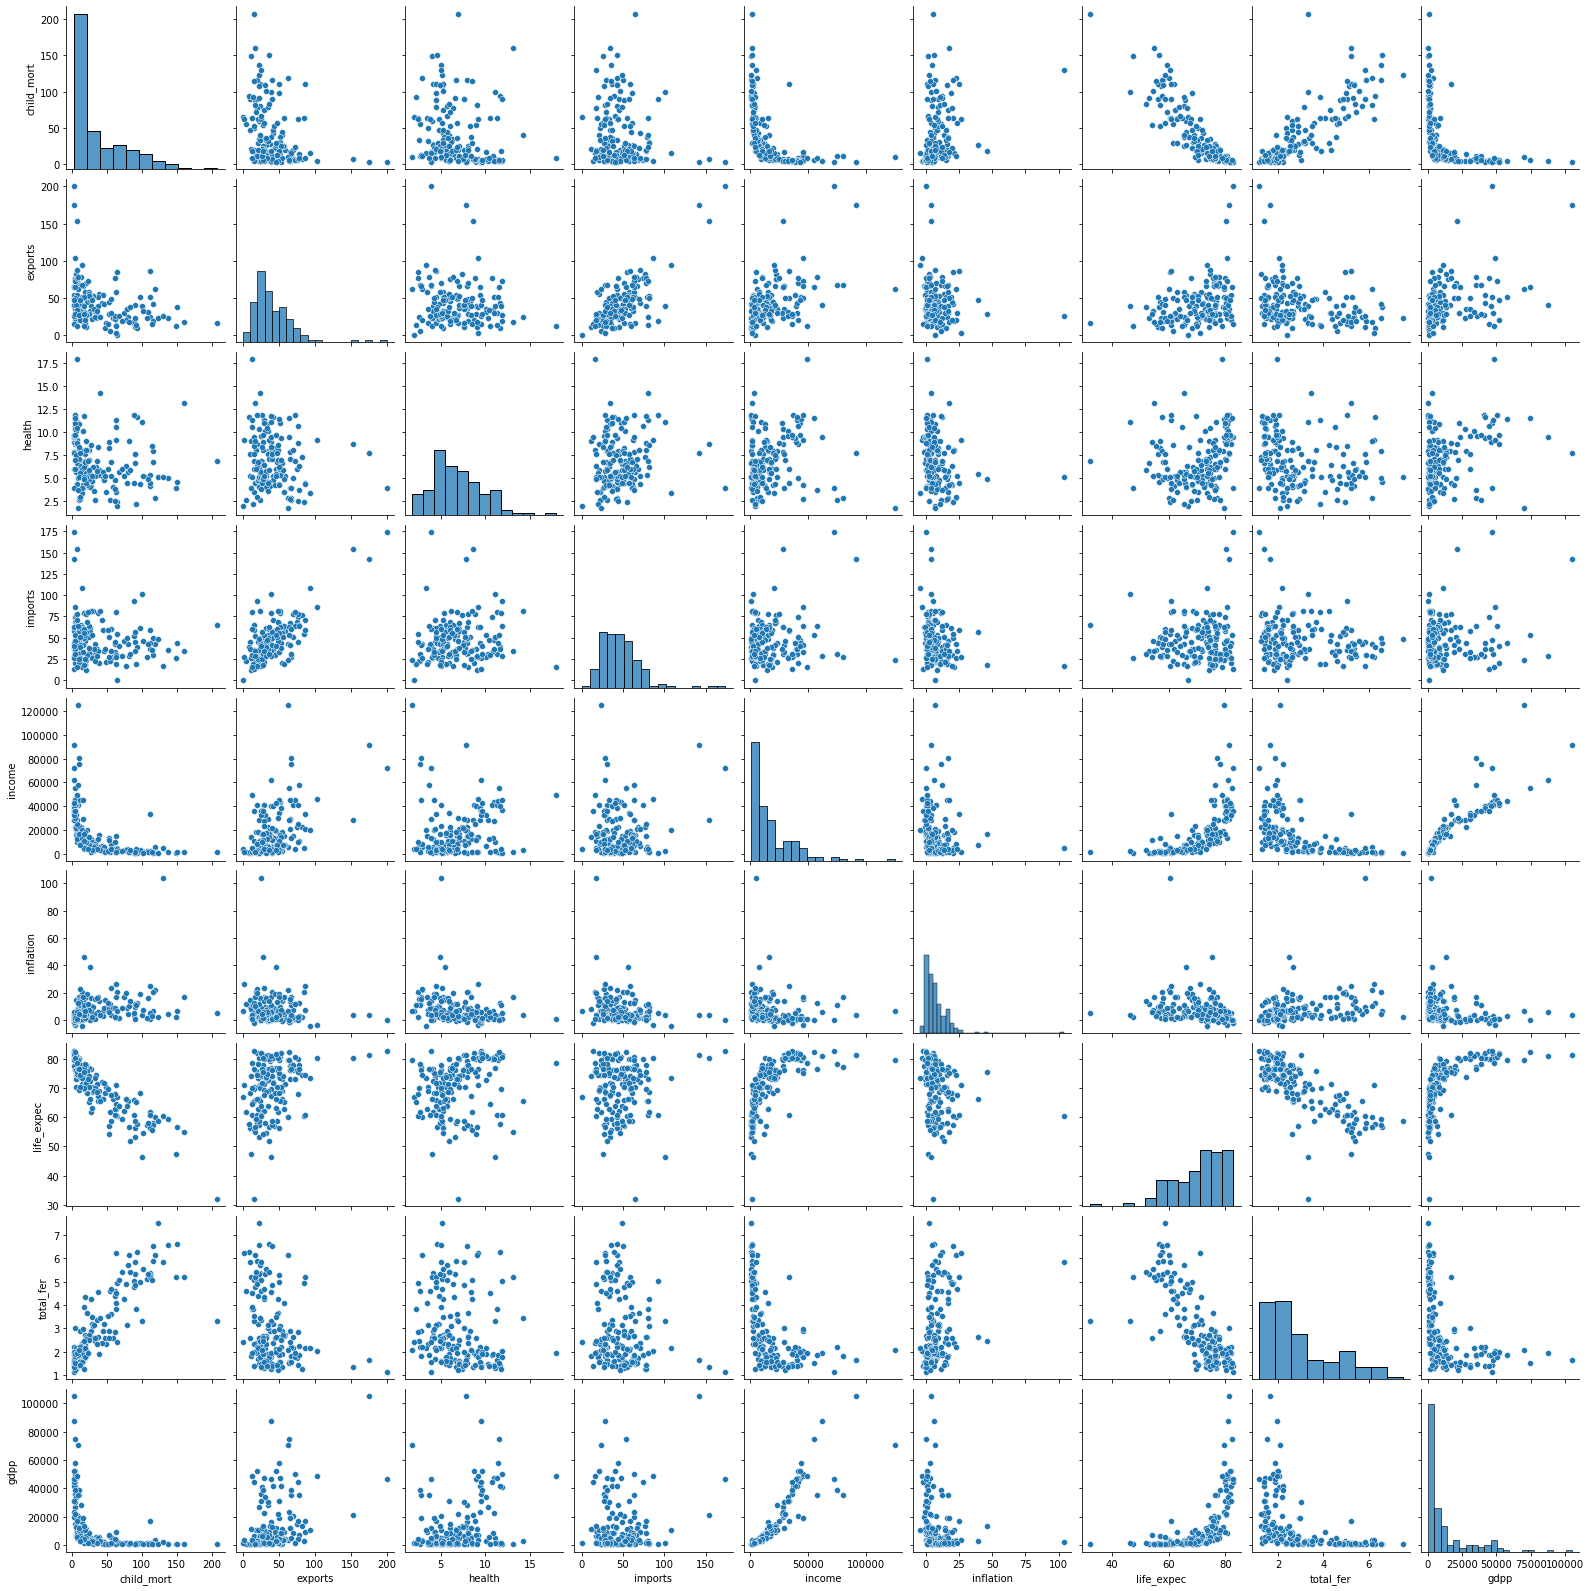

In [24]:
#Now lets do a pair plot. Pairplots help visualize correlations accross each pair
sns.pairplot(data_num)

## **Step 3 - Scaling the data**

- Clustering algorithms are distance-based algorithms, and all distance-based algorithms are affected by the scale of the variables. Therefore, we will scale the data before applying clustering.
- Dropping Country as it is unique. and GDP as we will perform data analysis after clustering

In [13]:
#drop country and GDP columns
data_new = data.drop(columns = ["country", "gdpp"])

In [14]:
# Scaling the data and storing the output as a new DataFrame

scaler = StandardScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data_new), columns = data_new.columns)

data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946


In [33]:
# Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep = True)

## **Step 4 - K-Means Clustering**

In [16]:
# Empty dictionary to store the SSE for each value of K
sse = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. 
# Use inertia attribute from the clustering object and store the inertia value for that K 
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled)
    sse[k] = kmeans.inertia_



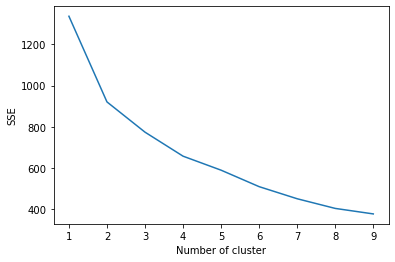

In [32]:
# Now lets do an Elbow plot of key and value pairs from the dictionary above. The keys are k and values are the SSE calculated aboe
plt.figure()

plt.plot(list(sse.keys()), list(sse.values()))

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

**Observations:**

- There is no clear 'elbow'
- So, let's look at another method to get a 'second opinion'. Let's create a plot with Silhouette scores to see how it varies with K.
- A silhoutte score ranges from -1 to +1. Higher values show better fit within the cluster, so we are looking to maximize it.
- It calculates how close you are to your neighbors and how far are you from other clusters

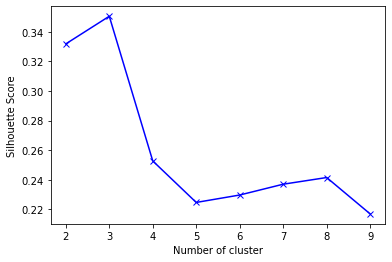

In [29]:
# Empty dictionary to store the Silhouette score for each value of K
sc = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that K 
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled)
    
    labels = kmeans.predict(data_scaled)
    
    sc[k] = silhouette_score(data_scaled, labels)

# Elbow plot
plt.figure()

plt.plot(list(sc.keys()), list(sc.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("Silhouette Score")

plt.show()

**Observation:**

- We observe from the plot that the silhouette score is the highest for K=3.

In [34]:
kmeans = KMeans(n_clusters = 3, random_state = 1)

kmeans.fit(data_scaled)

# Adding predicted labels to the original data and the scaled data 
data_scaled_copy['KMeans_Labels'] = kmeans.predict(data_scaled)

data['KMeans_Labels'] = kmeans.predict(data_scaled)

In [35]:
#Lets examine the clusters
data['KMeans_Labels'].value_counts()

0    112
1     52
2      3
Name: KMeans_Labels, dtype: int64

**Observation:**

- This looks like a very skewed clustering, There are only 3 observations in cluster 2.
- This could be because the underslying data is skewed. That is a drawback of k-means clustering as outliers can skew the clustering algorithm
- One way to tackle this is to use k-medioids. This replaces mean with median and is generally more practically for a skewed dataset.

## ** Step 5 - K-Medoids Clustering**

In [36]:
kmedo = KMedoids(n_clusters = 3, random_state = 1)

kmedo.fit(data_scaled)

data_scaled_copy['kmedoLabels'] = kmedo.predict(data_scaled)

data['kmedoLabels'] = kmedo.predict(data_scaled)

In [37]:
data.kmedoLabels.value_counts()

1    75
2    58
0    34
Name: kmedoLabels, dtype: int64

- This looks much more reasonable
- There are a lot of datapoints in each cluster, unlike K-means

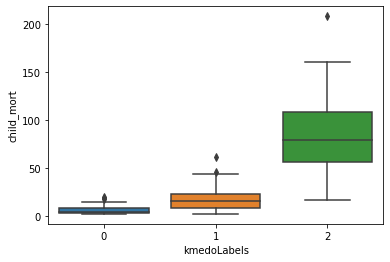

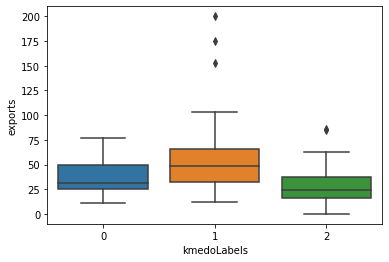

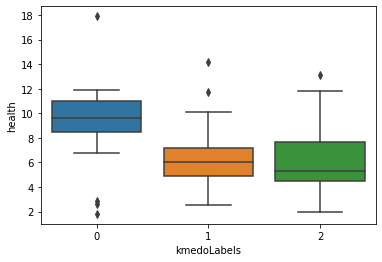

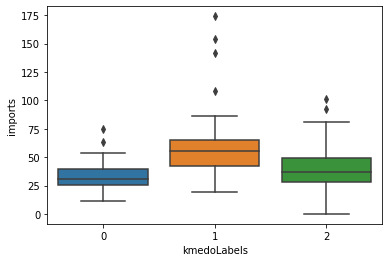

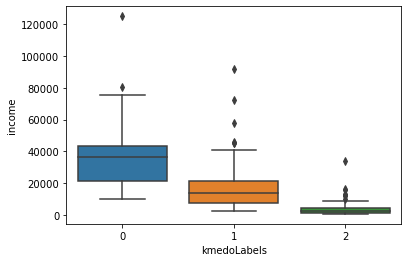

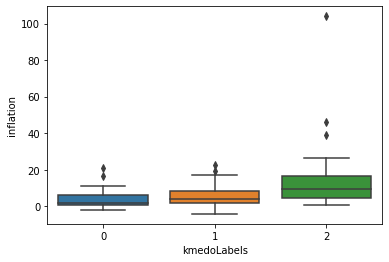

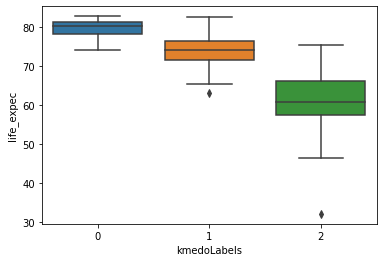

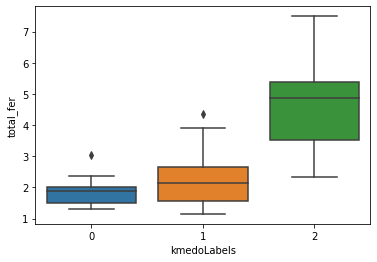

In [42]:
#Lets visualize the clusters using box plots
for col in data_new.columns:
    sns.boxplot(x = 'kmedoLabels', y = col, data = data)
    plt.show()

**Cluster Profiles:** 

- Cluster 2 looks like underdeveloped countries. Low income, high high mortality and inflation
- Cluster 1 looks like deeloping countries
- Cluster 0 shows developed countries. Highest income, life expectancy etc


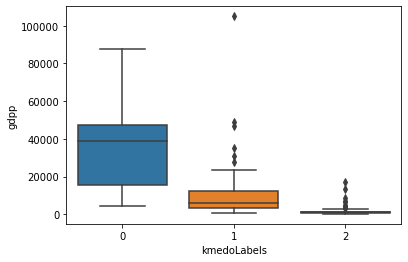

In [45]:
#Lets visualize the clusters using box plots
sns.boxplot(x = 'kmedoLabels', y = 'gdpp', data = data)
plt.show()

The GDP also confirms the same story. Cluster 0 has highest GDP, cluster 1 has medium GDP and cluster 2 has 0 GDP. This aligns with our observations above

## **Step 6 Gaussian Mixture Model**

In [46]:
#Using k = 3, lets fit the data to GMM and also make predictions on copied and raw dataset
gmm = GaussianMixture(n_components = 3, random_state = 1)

gmm.fit(data_scaled)

data_scaled_copy['GmmLabels'] = gmm.predict(data_scaled)

data['GmmLabels'] = gmm.predict(data_scaled)

In [34]:
#Lets inspect the cluster counts
data.GmmLabels.value_counts()

0    67
2    62
1    38
Name: GmmLabels, dtype: int64

This looks similar to K-medioids

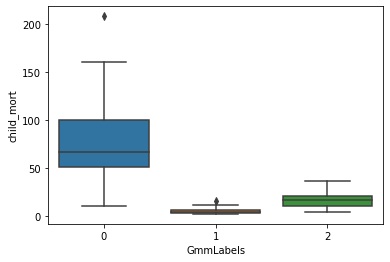

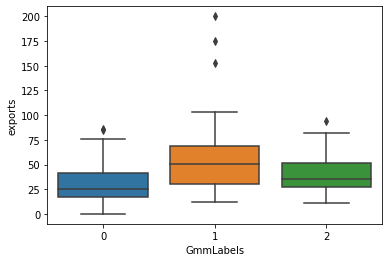

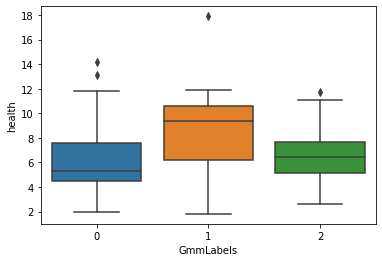

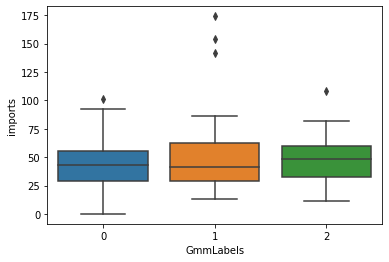

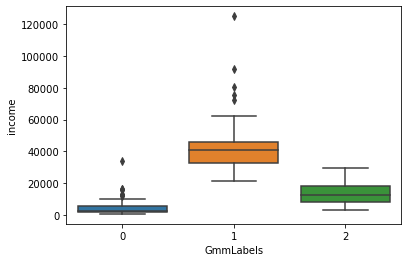

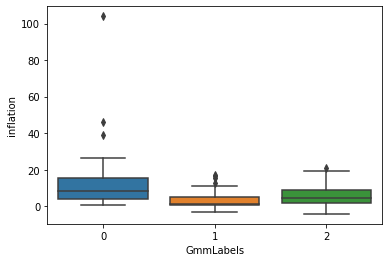

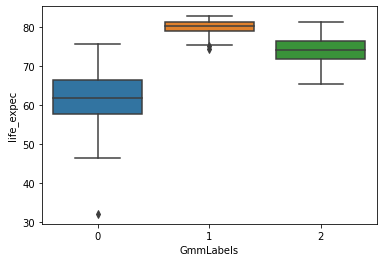

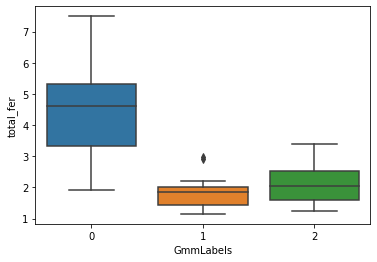

In [47]:
#lets plot boxplots for all the columns

for col in data_new.columns:
    sns.boxplot(x = 'GmmLabels', y = col, data = data)
    
    plt.show()

**Cluster Profiles:**

- Cluster 1 is developed countries, cluster 2 is developing and cluster 0 is under developed countries

- Cluster 1 values have all improved from K-mediods (so the cluster has become more 'pure')

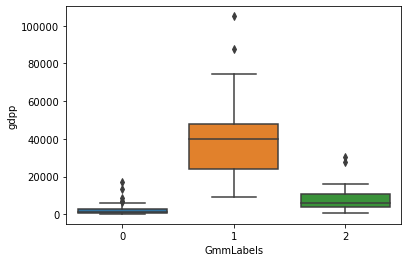

In [49]:
#Lets plot the GDP
sns.boxplot(x = 'GmmLabels', y = 'gdpp', data = data)
plt.show()

This reinforces our findings. Cluster 1 is developed, 2 is developing and 0 is under developed